In [3]:
#@title Set Up
%%capture
!pip install torchtext==0.8.0 
!pip install spacy==2.3.0
import gdown
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import numpy as np
import pandas as pd
import spacy
import random
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
!python -m spacy download en --quiet
!python -m spacy download de --quiet
spacy_german = spacy.load("de")
spacy_english = spacy.load("en")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def tokenize_german(text):
  return [token.text for token in spacy_german.tokenizer(text)]

def tokenize_english(text):
  return [token.text for token in spacy_english.tokenizer(text)]
german = Field(tokenize=tokenize_german,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")

english = Field(tokenize=tokenize_english,
               lower=True,
               init_token="<sos>",
               eos_token="<eos>")
train_data, _, _ = Multi30k.splits(exts = (".de", ".en"),
                                                    fields=(german, english))
german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

In [4]:
#@title LSTM
%%capture
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()

    self.hidden_size = hidden_size

    self.num_layers = num_layers

    self.dropout = nn.Dropout(p)
    self.tag = True

    self.embedding = nn.Embedding(input_size, embedding_size)
    
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)
  def forward(self, x):
    embedding = self.dropout(self.embedding(x))
    
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)

    return hidden_state, cell_state

class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()

  
    self.hidden_size = hidden_size

    self.num_layers = num_layers

  
    self.output_size = output_size

  
    self.dropout = nn.Dropout(p)


    self.embedding = nn.Embedding(input_size, embedding_size)

    
    self.LSTM = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = p)

    self.fc = nn.Linear(hidden_size, output_size)


  def forward(self, x, hidden_state, cell_state):

  
    x = x.unsqueeze(0)


    embedding = self.dropout(self.embedding(x))


    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))

    
    predictions = self.fc(outputs)

    
    predictions = predictions.squeeze(0)

    return predictions, hidden_state, cell_state


class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM

  def forward(self, source, target, tfr=0.5):
    
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = len(english.vocab)
  
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state, cell_state = self.Encoder_LSTM(source)

    x = target[0]

    for i in range(1, target_len):
      output, hidden_state, cell_state = self.Decoder_LSTM(x, hidden_state, cell_state)
      outputs[i] = output
      best_guess = output.argmax(1) 
      x = target[i] if random.random() < tfr else best_guess 
    return outputs

def translate_sentence(model, sentence, german, english, device, max_length=50):
    spacy_ger = spacy.load("de")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

  
    with torch.no_grad():
        hidden, cell = model.Encoder_LSTM(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell = model.Decoder_LSTM(previous_word, hidden, cell)
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    return translated_sentence[1:]
input_size_encoder = len(german.vocab)
encoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
encoder_dropout = 0.5

encoder_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size,
                           hidden_size, num_layers, encoder_dropout).to(device)
input_size_decoder = len(english.vocab)
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 2
decoder_dropout = 0.5
output_size = len(english.vocab)
decoder_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size,
                           hidden_size, num_layers, decoder_dropout, output_size).to(device)
model = Seq2Seq(encoder_lstm, decoder_lstm).to(device)
!gdown --id 1KlMMFpqXwLXLpQEBisZOg-uk6i8zy8rO
model.load_state_dict(torch.load('/content/checkpoint-NMT-SD4'))
model.eval()

In [13]:
#@title GRU
%%capture
from torch import Tensor
from typing import Tuple
def plot_most_likely_words(most_likely_words):
    import matplotlib.pyplot as plt
    import numpy as np
    sentence_length = len(most_likely_words)
    cols = 2
    rows = int(np.ceil(sentence_length / cols))
    fig = plt.figure(figsize=(12,16))
    for i in range(sentence_length):
        probabilities, words = most_likely_words[i]
        plt.subplot(rows,cols,i+1)
        plt.bar(words, probabilities.cpu())
        plt.yticks([0.,0.2,0.4,0.6,0.8,1.])
    plt.tight_layout()
    plt.show()
class Encoder2(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self,
                src: Tensor) -> Tuple[Tensor]:

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)


class Decoder2(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor,
                              return_attn=False) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        if return_attn:
            return weighted_encoder_rep, a.flatten()
        return weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor,
                return_attn=False) -> Tuple[Tensor]:

        input = input.unsqueeze(0)

        embedded = self.dropout(self.embedding(input))

        if return_attn:
            weighted_encoder_rep, attn = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs, return_attn=return_attn)
        else:
            weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)

        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        if return_attn:
            return output, decoder_hidden.squeeze(0), attn
        return output, decoder_hidden.squeeze(0)


class Seq2Seq2(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # first input to the decoder is the <sos> token
        output = trg[0,:]

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

def make_model(INPUT_DIM, OUTPUT_DIM, ENC_EMB_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, DEC_DROPOUT, ATTN_DIM, device):
    "Helper: Construct a model from hyperparameters."
    enc = Encoder2(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)
    dec = Decoder2(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq2(enc, dec, device)
    
    model.apply(init_weights)
    return model
def get_most_likely_words(number_of_words, output, field):
    output = torch.softmax(output, dim=0)
    values, indices = torch.topk(output, number_of_words, largest=True)
    return values, [field.vocab.itos[idx] for idx in indices]
def translate_sentence2(model, sentence, german, english, device, max_length=50, multiple_guesses=0):
    import spacy
    spacy_ger = spacy.load("de")
    model.eval()

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    best_guesses = []
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden = model.decoder(previous_word, hidden, encoder_outputs)
            if multiple_guesses > 1:
                best_guesses.append(get_most_likely_words(multiple_guesses, output.flatten(), english))
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]
    if multiple_guesses > 1:
        return translated_sentence[1:], best_guesses
    return translated_sentence[1:]
SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

train_data, _,_= Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
del train_data 
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
ATTN_DIM = 64
args = (INPUT_DIM,OUTPUT_DIM,ENC_EMB_DIM,DEC_EMB_DIM,ENC_HID_DIM,DEC_HID_DIM,ENC_DROPOUT,DEC_DROPOUT,ATTN_DIM)
kwargs = {"device" : device}

!gdown --id 1iw44lPbg1Xx6dxjceRHwsvLGA0AdjsrT
model3 = make_model(*args, **kwargs).to(device)
model_name = "/content/torch_Seq2Seq"
state = torch.load(model_name + ".pt", map_location=device)
model3.load_state_dict(state["state_dict"])
model3.eval()


In [7]:
#@title Transformers
%%capture
import copy
import math
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys
!gdown --id 1EkMLmEKfxZVQCiyim-iDuKGtwiD0rgx8
model4 = make_model(INPUT_DIM,OUTPUT_DIM).to(device)
model_name = "/content/harvard_transformer2_state"
state = torch.load(model_name + ".pt", map_location=device)
model4.load_state_dict(state["state_dict"])
model4.eval()

In [20]:
sentence = "eine gruppe von menschen steht vor einem iglu ."
#plots dont work well with long sentences

In [21]:
#@title Translate
print("LSTM: "+" ".join(translate_sentence(model, sentence , german, english, device)[:-1]))
translation, likely = translate_sentence2(model3, sentence, SRC, TRG, device, max_length=50, multiple_guesses=10)
print("GRU: "+" ".join(translation[:-1]))
sentence1 = [SRC.preprocess(sentence)]
src = SRC.process(sentence1).to(device).T
src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
model4.eval()
out = greedy_decode(model4, src, src_mask, max_len=60, start_symbol=TRG.vocab.stoi["<sos>"])
translation = []
for i in range(1, out.size(1)):
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "<eos>":
        break
    else:
      translation.append(sym)
print("Transformer: " + ' '.join(translation))

LSTM: a group of people standing in front of a building .
GRU: a group of people standing in front of a theater .
Transformer: a group of people are standing in front of a large building .


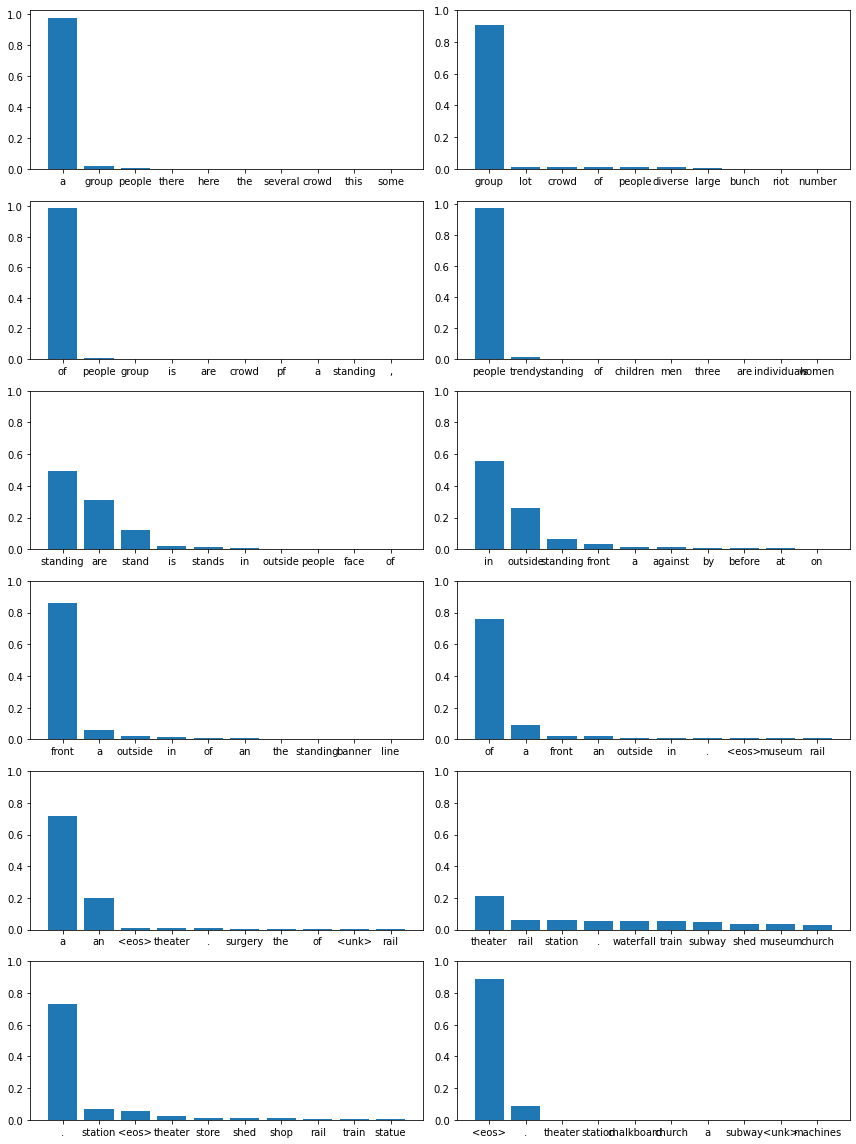

In [22]:
#@title GRU most likely words
plot_most_likely_words(likely)

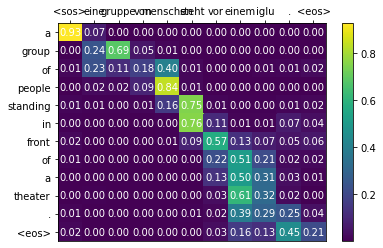

In [34]:
#@title GRU attention
import matplotlib.pyplot as plt
def plot_heatmap(src, trg, scores):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(scores, cmap='viridis')
    for (i, j), z in np.ndenumerate(scores):
        ax.text(j + 0.5, i + 0.5, '{:0.2f}'.format(z), ha='center', va='center', color='w')


    ax.set_xticklabels(trg, minor=False, rotation='horizontal')
    ax.set_yticklabels(src, minor=False)

    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

def plot_attention(model, sentence, german, english, device, max_length=50):
    spacy_ger = spacy.load("de")

    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)
    text_to_indices = [german.vocab.stoi[token] for token in tokens]
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    attention_matrix = []
    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, attn = model.decoder(previous_word, hidden, encoder_outputs, return_attn=True)
            best_guess = output.argmax(1).item()
            # print(english.vocab.itos[best_guess])
            # print(attn*100)

        outputs.append(best_guess)
        attention_matrix.append(attn.cpu().numpy())

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs[1:]]
    attention = np.array(attention_matrix)
    plot_heatmap(translated_sentence, tokens, attention)
plot_attention(model3, sentence, SRC, TRG, device)

Encoder Layer 2


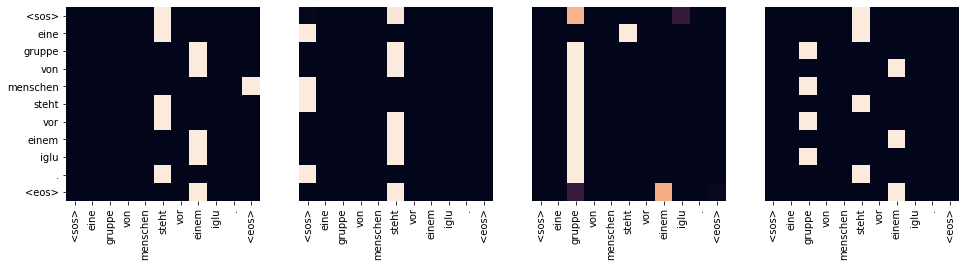

Encoder Layer 4


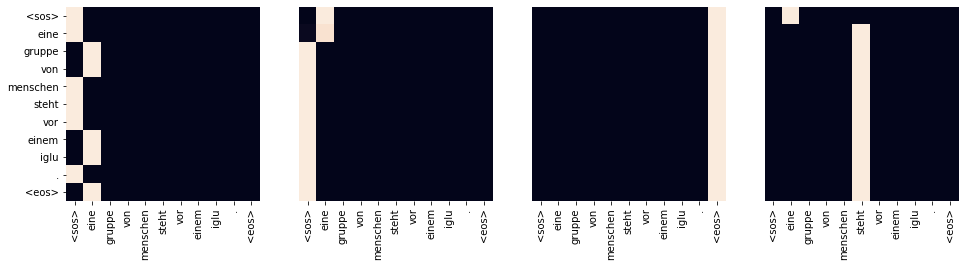

Encoder Layer 6


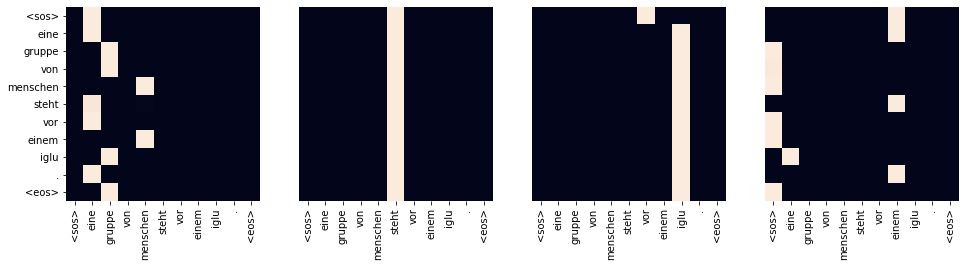

Decoder Self Layer 2


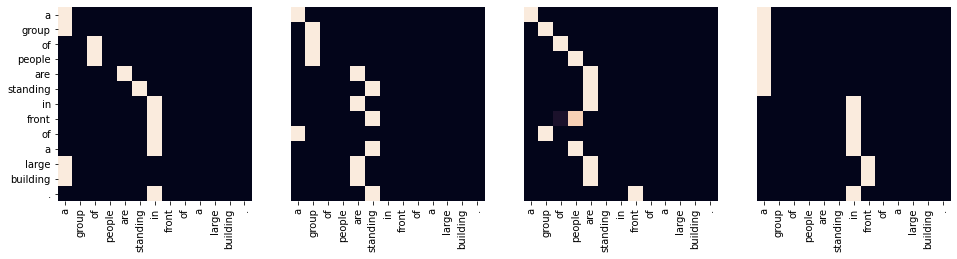

Decoder Src Layer 2


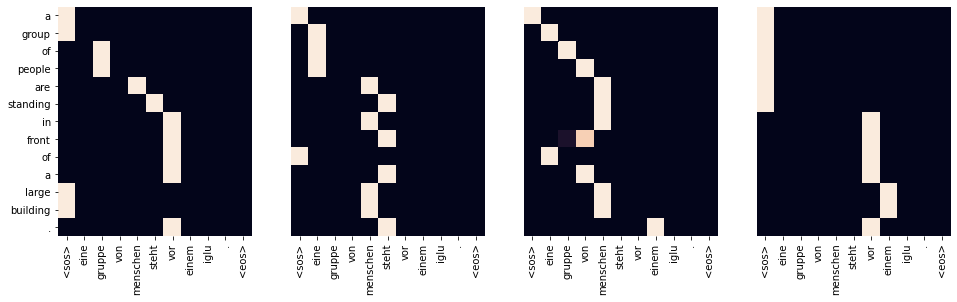

Decoder Self Layer 4


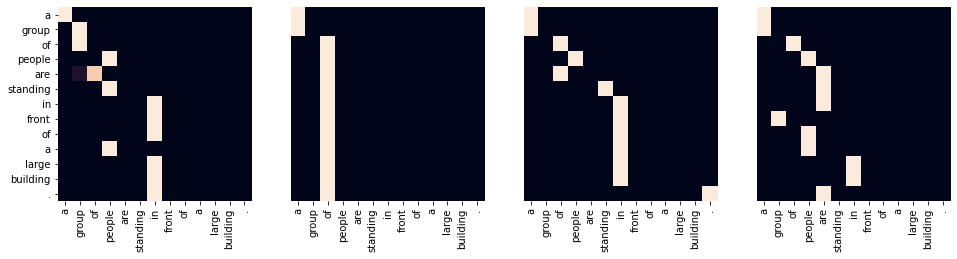

Decoder Src Layer 4


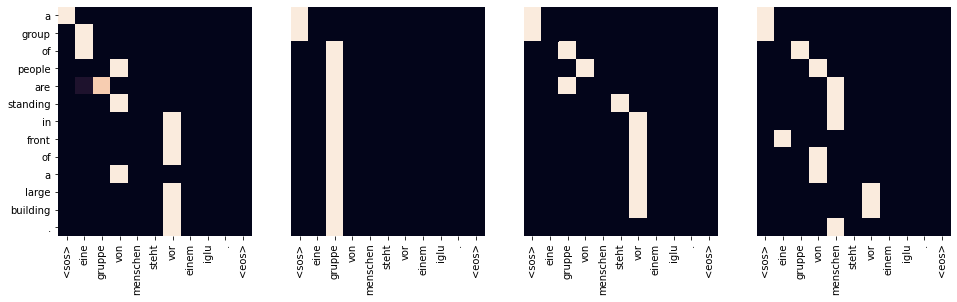

Decoder Self Layer 6


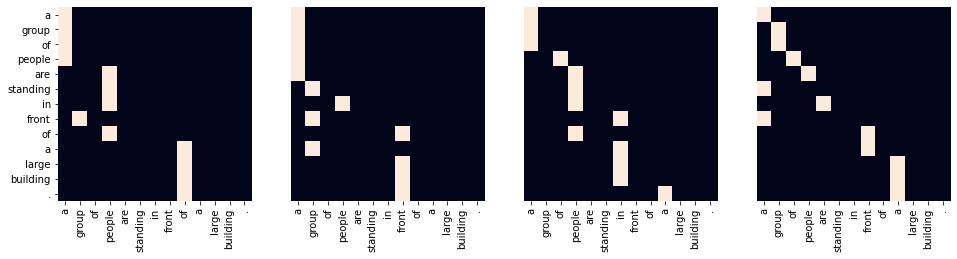

Decoder Src Layer 6


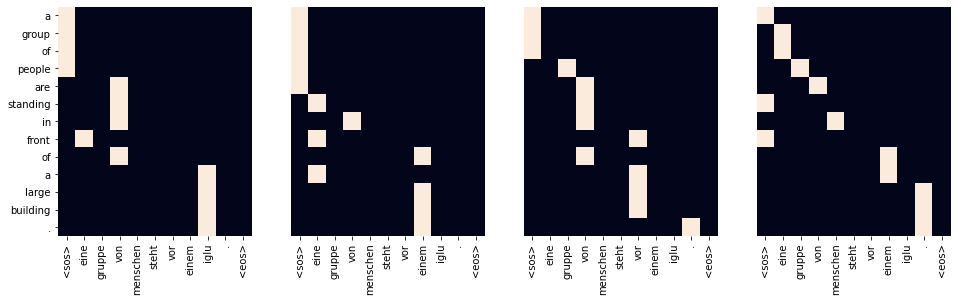

In [39]:
#@title Transformer attention
import seaborn
def visualise_attention(tgt_sent, sent):
    def draw(data, x, y, ax):
        seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    for layer in range(1, 6, 2):
        fig, axs = plt.subplots(1,4, figsize=(16, 5))
        print("Encoder Layer", layer+1)
        for h in range(4):
            vals = model4.encoder.layers[layer].self_attn.attn[0, h].data.cpu()
            draw(vals, sent, sent if h ==0 else [], ax=axs[h])
        plt.show()
        
    for layer in range(1, 6, 2):
        fig, axs = plt.subplots(1,4, figsize=(16, 5))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            vals = model4.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)].cpu()
            draw(vals, tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
        plt.show()
        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1,4, figsize=(16, 5))
        for h in range(4):
            vals = model4.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)].cpu()
            draw(vals, sent, tgt_sent if h ==0 else [], ax=axs[h])
        plt.show()
visualise_attention(translation, ["<sos>"] + sentence1[0] + ["<eos>"])

In [ ]:
#@title BERT2BERT
%%capture
del model
del model3
del model4
!pip install transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("google/bert2bert_L-24_wmt_de_en", pad_token="<pad>", eos_token="</s>", bos_token="<s>")
model2 = AutoModelForSeq2SeqLM.from_pretrained("google/bert2bert_L-24_wmt_de_en")
input_ids = tokenizer(sentence, return_tensors="pt", add_special_tokens=False).input_ids
output_ids = model2.generate(input_ids)[0]
print("BERT2BERT: "+tokenizer.decode(output_ids, skip_special_tokens=True))